In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
import copy
import os

import matplotlib.cm as mpl_color_map
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import ReLU
from PIL import Image, ImageFilter
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models
from utils import SAVE_DIR, load_checkpoint, model_selector
from tqdm import tqdm


In [134]:
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name, ext='.png', savedir='../pytorch_visualizations/results'):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    # Save path
    path_to_file = os.path.join(savedir, file_name + ext)
    if os.path.isfile(path_to_file):
        return None

    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()

    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name, ext='.png', savedir='../pytorch_visualizations/results'):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join(savedir, file_name+'_Cam_Heatmap' + ext)
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join(savedir, file_name+'_Cam_On_Image'+ ext)
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join(savedir, file_name+'_Cam_Grayscale' + ext)
    if os.path.isfile(path_to_file):
        return None
    
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('../pytorch_visualizations/input_images/snake.jpg', 56),
                    ('../pytorch_visualizations/input_images/cat_dog.png', 243),
                    ('../pytorch_visualizations/input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [4]:
setting = "photobox"
df_train = pd.read_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val = pd.read_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test = pd.read_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

topclasses = df_train['txt_label'].unique().tolist()

modelname = "vgg16"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)
optimizer = optim.Adam(model.parameters(), lr=.001)

model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)

labelticks = list({'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}.keys())
labeldict = {'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}
class_names = {str(v): [k,k] for k, v in labeldict.items()}
print(f"Class_names : {class_names}")
print(f"Topclasses: {topclasses}")

Class_names : {'0': ['bl', 'bl'], '1': ['wswl', 'wswl'], '2': ['sp', 'sp'], '3': ['t', 't'], '4': ['sw', 'sw'], '5': ['k', 'k'], '6': ['m', 'm'], '7': ['c', 'c'], '8': ['v', 'v'], '9': ['wmv', 'wmv'], '10': ['wrl', 'wrl']}
Topclasses: ['t', 'c', 'sw', 'wmv', 'v', 'bl', 'wswl', 'm', 'k', 'sp', 'wrl']


## generate_regularized_class_specific_samples

In [5]:
use_cuda = torch.cuda.is_available()

class RegularizedClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent. Uses Gaussian blur, weight decay, and clipping. 
    """

    def __init__(self, model, target_class):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model.cuda() if use_cuda else model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(0, 255, (224, 224, 3)))
        # Create the folder to export images if not exists
        if not os.path.exists(f'../pytorch_visualizations/generated/class_{self.target_class}'):
            os.makedirs(f'../pytorch_visualizations/generated/class_{self.target_class}')

    def generate(self, iterations=150, blur_freq=4, blur_rad=1, wd=0.0001, clipping_value=0.1):
        """Generates class specific image with enhancements to improve image quality. 
        See https://arxiv.org/abs/1506.06579 for details on each argument's effect on output quality. 
        

        Play around with combinations of arguments. Besides the defaults, this combination has produced good images:
        blur_freq=6, blur_rad=0.8, wd = 0.05

        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
            blur_freq {int} -- Frequency of Gaussian blur effect, in iterations (default: {6})
            blur_rad {float} -- Radius for gaussian blur, passed to PIL.ImageFilter.GaussianBlur() (default: {0.8})
            wd {float} -- Weight decay value for Stochastic Gradient Ascent (default: {0.05})
            clipping_value {None or float} -- Value for gradient clipping (default: {0.1})
        
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = 6
        for i in range(1, iterations):
            # Process image and return variable

            #implement gaussian blurring every ith iteration
            #to improve output
            if i % blur_freq == 0:
                self.processed_image = preprocess_and_blur_image(
                    self.created_image, False, blur_rad)
            else:
                self.processed_image = preprocess_and_blur_image(
                    self.created_image, False)

            if use_cuda:
                self.processed_image = self.processed_image.cuda()

            # Define optimizer for the image - use weight decay to add regularization
            # in SGD, wd = 2 * L2 regularization (https://bbabenko.github.io/weight-decay/)
            optimizer = SGD([self.processed_image],
                            lr=initial_learning_rate, weight_decay=wd)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i in np.linspace(0, iterations, 10, dtype=int):
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.cpu().numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()

            if clipping_value:
                torch.nn.utils.clip_grad_norm(
                    self.model.parameters(), clipping_value)
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image.cpu())

            if i in np.linspace(0, iterations, 10, dtype=int):
                # Save image
                im_path = f'../pytorch_visualizations/generated/class_{self.target_class}/c_{self.target_class}_iter_{i}_loss_{class_loss.data.cpu().numpy()}.jpg'
                save_image(self.created_image, im_path)

        #save final image
        im_path = f'../pytorch_visualizations/generated/class_{self.target_class}/c_{self.target_class}_iter_{i}_loss_{class_loss.data.cpu().numpy()}.jpg'
        save_image(self.created_image, im_path)

        #write file with regularization details
        with open(f'../pytorch_visualizations/generated/class_{self.target_class}/run_details.txt', 'w') as f:
            f.write(f'Iterations: {iterations}\n')
            f.write(f'Blur freq: {blur_freq}\n')
            f.write(f'Blur radius: {blur_rad}\n')
            f.write(f'Weight decay: {wd}\n')
            f.write(f'Clip value: {clipping_value}\n')

        #rename folder path with regularization details for easy access
        os.rename(f'../pytorch_visualizations/generated/class_{self.target_class}',
                  f'../pytorch_visualizations/generated/class_{self.target_class}_blurfreq_{blur_freq}_blurrad_{blur_rad}_wd{wd}')
        return self.processed_image


def preprocess_and_blur_image(pil_im, resize_im=True, blur_rad=None):
    """
        Processes image with optional Gaussian blur for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
        blur_rad (int): Pixel radius for Gaussian blurring (default = None)
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print(
                "could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))

    #add gaussin blur to image
    if blur_rad:
        pil_im = pil_im.filter(ImageFilter.GaussianBlur(blur_rad))

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    if use_cuda:
        im_as_var = Variable(im_as_ten.cuda(), requires_grad=True)
    else:
        im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

/tmp/ipykernel_1071144/1878487574.py:72: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 16 Loss 0.27
Iteration: 33 Loss -1.50
Iteration: 50 Loss -3.72
Iteration: 66 Loss -4.29
Iteration: 83 Loss -4.82
Iteration: 100 Loss -4.78
Iteration: 116 Loss -5.21
Iteration: 133 Loss -5.74


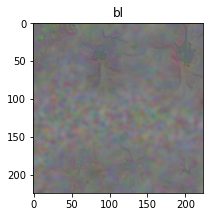

In [6]:
plt.figure(figsize=(14,12));

for target_class in list(class_names.keys()):
    target_class = int(target_class)
    plt.subplot(3,4,target_class+1);
    pretrained_model = model
    csig = RegularizedClassSpecificImageGeneration(pretrained_model, target_class);
    csig.generate();

    
    plt.imshow(csig.created_image);
    plt.title(class_names[str(target_class)][0])
    break

## layer_activation_with_guided_backprop

In [7]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class, cnn_layer, filter_pos):
        self.model.zero_grad()
        # Forward pass
        x = input_image
        for index, layer in enumerate(self.model.features):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == cnn_layer:
                # (forward hook function triggered)
                break
        conv_output = torch.sum(torch.abs(x[0, filter_pos]))
        # Backward pass
        conv_output.backward()
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [87]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [142]:
df_test[df_test.label==9].filename.iloc[402]
# '/mnt/EE7455C074558BE9/backups/data_backups/images/photobox_vs_fuji/photobox/wmv/2021_UNDISTORTED_landen_B_w26_4056x3040.png_wmv_4641.png'

cnn_layer = 28
filter_pos = 15

target_class = 9
# ii = np.random.randint(0,405)
ii=45
print(ii)
pretrained_model = model.cpu()

for filter_pos in tqdm([0,5,10,15,20,25,30,35,40,45,50,55]):
    for cnn_layer in [0,2,5,7,10,12,14,17,19,21,24,26,28]:
        
        img_path = df_test[df_test.label==target_class].filename.iloc[ii]

        file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
        # Read image
        original_image = Image.open(img_path).convert('RGB')
        # Process image
        prep_img = preprocess_image(original_image)
        # Define model
        
        # File export name
        file_name_to_export = file_name_to_export + '_layer' + str(cnn_layer) + '_filter' + str(filter_pos)

        # Guided backprop
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, target_class, cnn_layer, filter_pos)
        
        # Save colored gradients
        save_gradient_images(guided_grads, file_name_to_export, savedir=f'../pytorch_visualizations/results/Guided_BP_color/cnn_layer_{cnn_layer}')
        # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        # Save grayscale gradients
        save_gradient_images(grayscale_guided_grads, file_name_to_export, savedir=f'../pytorch_visualizations/results/Guided_BP_gray/cnn_layer_{cnn_layer}')
        # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        save_gradient_images(pos_sal, file_name_to_export, savedir=f'../pytorch_visualizations/results/pos_sal/cnn_layer_{cnn_layer}')
        save_gradient_images(neg_sal, file_name_to_export, savedir=f'../pytorch_visualizations/results/neg_sal/cnn_layer_{cnn_layer}')
        # print('Layer Guided backprop completed')

45


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [59:14<00:00, 296.23s/it]


In [133]:
file_name_to_export

'2020_UNDISTORTED_merchtem_20200915_M2_4056x3040.png_wmv_26777_layer10_filter10'